In [117]:
import numpy as np
import matplotlib.pyplot as plt
import csv, datetime, os
import matplotlib.dates as mdates
import pandas as pd
from sklearn.metrics import r2_score
import pandas as pd


def MakeDataFromText(filepath:str):
    """
    Helper function to parse text files in IFM proprietary format.
    """
    with open(filepath, 'r') as file:
        reader = csv.reader(file)

        db = dict()                          # Dictionary that will hold k,v pairs of 
        recent_EPC = ''                      # The most recent EPC that was read, and data is being assigned to
        Time_Or_Data = True                  # Time is true, Data is false
        reached_24 = False

        for l in reader:                     # Iterate over entire text file
            line = l[0]                      # Each line only has one token, so we select it
            
            if len(line)==24:                # If it is an EPC
                db[line] = [[],[]]           # Create new k,v pair in database
                recent_EPC = line            # Current EPC to add to is selected
            
            elif line == '[':                # If start bracket, beginning to collect an array of data
                data = []

            elif line == ']':                # End bracket means end of data array
                if len(data)!=0:
                    if Time_Or_Data:
                        db[recent_EPC][0] = data
                        Time_Or_Data = False
                    else:
                        db[recent_EPC][1] = data
                        Time_Or_Data = True
                data = []

            elif line.count(":")==2:
                h,m,s = line.split(':')      # Parse timestamp into hours, minutes, seconds

                if int(h)==23:
                    reached_24 = True        # If end of day reached, must move to Day 2

                if reached_24 and int(h) < 12:
                    day=2
                else:
                    day=1

                data.append(datetime.datetime(1970, 2, day, int(h), int(m), int(s)))
            
            elif line ==' ':               # If blank space, then we skip to parse next line
                pass

            else:                          # If it is a data point
                try:
                    data.append(float(line))
                except:
                    pass                   # Error catching case just in case, so annoying errors don't crash program
    return db


def MakeDict(data:list):
    """
    """
    t1234 = dict()
    for d in data:
        for k,v in d.items():
            if k in t1234: # if tag is already in dict
                for i in range(len(v[0])):
                    if v[0][i] in t1234[k]:
                        t1234[k][v[0][i]].append(v[1][i])
                    else:
                        t1234[k][v[0][i]] = [v[1][i]]
            else:             # if tag is not in dict
                t1234[k] = dict()
                for i in range(len(v[0])):
                    t1234[k][v[0][i]] = [v[1][i]]
    for k,v in t1234.items():
        for k2,v2 in v.items():
            t1234[k][k2] = sum(v2)/len(v2)
    return t1234

In [118]:
# rssi = MakeDict( [ MakeDataFromText('CHANGING/05092023 1637 start/RSSI_23300.csv') ] )
# temp = MakeDict( [ MakeDataFromText('CHANGING/05092023 1637 start/tags_23300.csv') ] )

rssi = MakeDict( [ MakeDataFromText('CHANGING/05112023 moving/RSSI_30897.csv') ] )
temp = MakeDict( [ MakeDataFromText('CHANGING/05112023 moving/tags_30897.csv') ] )

In [119]:
# water = pd.read_csv( 'CHANGING/05092023 1637 start/water temp 05-10-2023.csv', skiprows=0, sep=',', header=0 ) # up to 62

water = pd.read_csv( 'CHANGING/05112023 moving/water temp 05-11-23.csv', skiprows=0, sep=',', header=0 )
water.columns = [ 'Timestamp', 'Serial Number', 'Channel', 'Data', 'Unit of Measure' ]
water = water.iloc[:74]

s1_time, s1_data, s2_time, s2_data = [], [], [], []

for i in range(74):
    _,hms = water['Timestamp'][i].split(' ')
    h,m = hms.split(':')
    time = datetime.datetime(1970, 2, 1, int(h[-2:]), int(m), 0)

    if water['Channel'][i]==1:
        s1_data.append(water['Data'][i])
        s1_time.append(time)
    
    elif water['Channel'][i]==2:
        s2_data.append(water['Data'][i])
        s2_time.append(time)

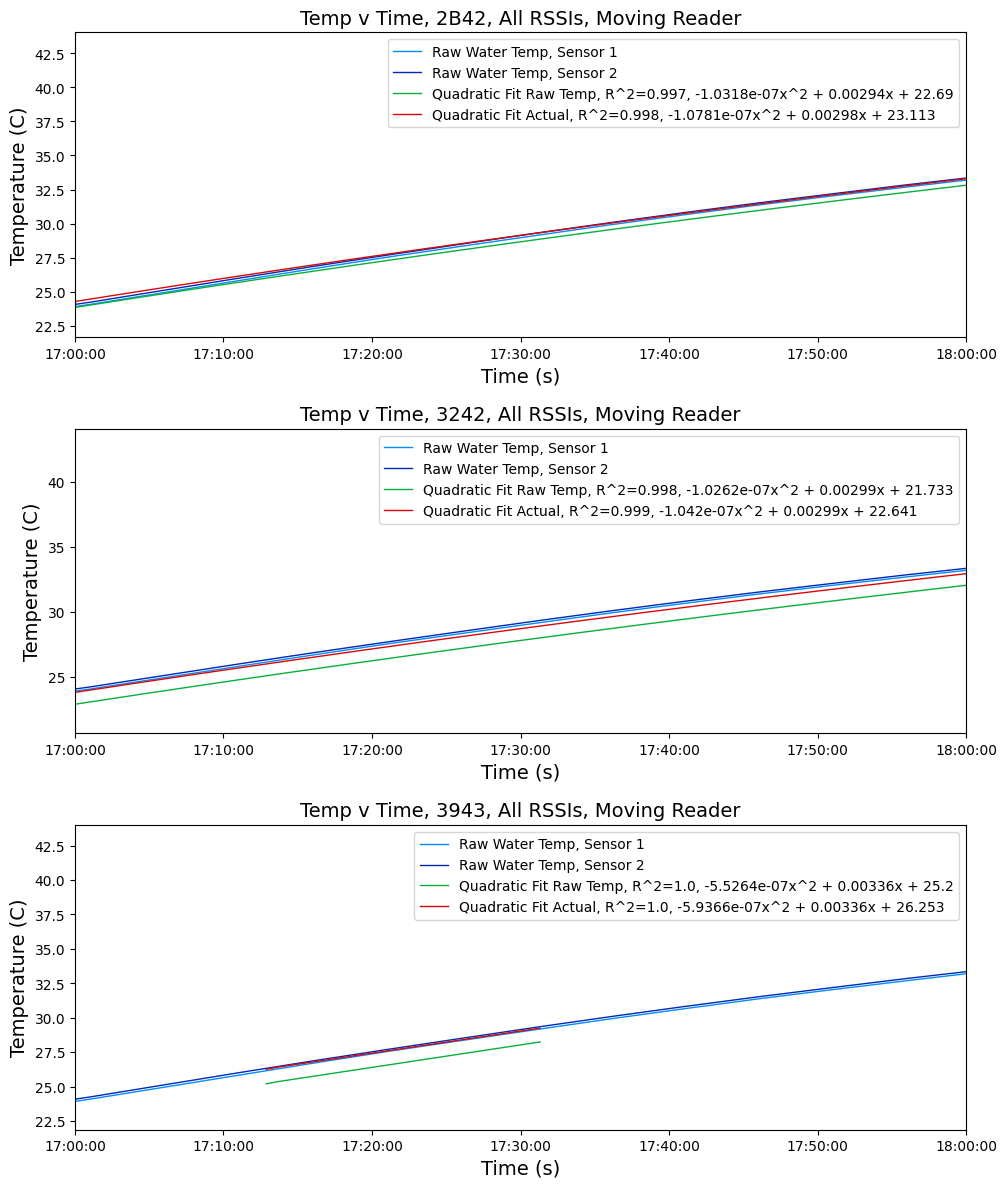

In [120]:
fig, (ax1,ax2, ax3) = plt.subplots(3, 1, figsize=(11.5, 14.25), sharex=True)
fig.subplots_adjust(hspace=0.3)
axs = [ ax1, ax2, ax3 ]

for a__ in axs:
    a__.xaxis.set_major_formatter( mdates.DateFormatter('%H:%M:%S') )
    a__.tick_params(labelbottom=True)

ax1.set_xlim( [datetime.datetime(1970, 2, 1, 17, 0, 0), datetime.datetime(1970, 2, 1, 18, 0, 0)] )
TAGS = [ '2B42', '3242', '3943' ]

for i in range(3):
    for k,v in temp.items():
        if k[-4:]==TAGS[i]:
            st, sr = sorted(temp[k].items()), sorted(rssi[k].items())
            dt = [ j[1] for j in st if j[0] > datetime.datetime(1970, 2, 1, 16, 23, 30) ]
            tt = [ j[0] for j in st if j[0] > datetime.datetime(1970, 2, 1, 16, 23, 30) ]
            dr = [ j[1] for j in sr if j[0] > datetime.datetime(1970, 2, 1, 16, 23, 30) ]
            
            new_dt, new_tt = [], []
            for p in range(len(dr)):
                if i==0:    actual = 0.032 * (9.83  - float(dr[p])) + float(dt[p]) + 0.6368;
                elif i==1:  actual = 0.037 * (22.53 - float(dr[p])) + float(dt[p]) + 0.5043;
                elif i==2:  actual = 0.048 * (2.84  - float(dr[p])) + float(dt[p]) + 1.0122;
                new_dt.append(actual); new_tt.append(tt[p])

            # axs[i].plot(s1_time, s1_data, label='Raw Water Temp, Sensor 1', linewidth=1.0, color="#048CF9", marker=".")
            # axs[i].plot(s2_time, s2_data, label='Raw Water Temp, Sensor 2', linewidth=1.0, color="#012AB3", marker=".")
            
            axs[i].plot( s1_time, s1_data, label='Raw Water Temp, Sensor 1', linewidth=1.0, color="#048CF9" )
            axs[i].plot( s2_time, s2_data, label='Raw Water Temp, Sensor 2', linewidth=1.0, color="#012AB3" )

            # axs[i].plot(tt, dt, label=TAGS[i] + ", Raw Temp.", linewidth=0.8, color="#028F0A")
            # axs[i].plot(new_tt, new_dt, label=TAGS[i] + ", Actual Temp. Equation", linewidth=0.8, color="#d10101")

            t_raw = np.array([ (j___ - tt[0]).total_seconds() for j___ in tt ])
            t_act = np.array([ (j___ - new_tt[0]).total_seconds() for j___ in new_tt ])
            model_raw, model_act = np.poly1d( np.polyfit(t_raw, dt,  2) ), np.poly1d( np.polyfit(t_act, new_dt,  2) )
            strmodel2_ = ", " + str(round(model_raw[2], 11))+"x^2 + "+str(round(model_raw[1], 5))+"x + "+str(round(model_raw[0], 3))
            str_act    = ", " + str(round(model_act[2], 11))+"x^2 + "+str(round(model_act[1], 5))+"x + "+str(round(model_act[0], 3))
            r2_raw = r2_score(dt, model_raw(t_raw))
            r2_act = r2_score(new_dt, model_act(t_act))

            axs[i].plot(tt, model_raw(t_raw), label='Quadratic Fit Raw Temp, R^2='+str(round(r2_raw, 3))+strmodel2_, linewidth=1.0, color="#07B03D")
            axs[i].plot(new_tt, model_act(t_act), label='Quadratic Fit Actual, R^2='+str(round(r2_act, 3))+str_act, linewidth=1.0, color="#DA0606")


            _s1t, _s2t = [ (j-s1_time[0]).total_seconds() for j in s1_time ], [ (j-s2_time[0]).total_seconds() for j in s2_time ]
            # if True:
            #     models1 = np.poly1d( np.polyfit(_s1t, s1_data,  2) )
            #     models2 = np.poly1d( np.polyfit(_s2t, s2_data,  2) )
            #     strs1 = ", " + str(round(models1[2], 11))+"x^2 + "+str(round(models1[1], 5))+"x + "+str(round(models1[0], 3))
            #     strs2 = ", " + str(round(models2[2], 11))+"x^2 + "+str(round(models2[1], 5))+"x + "+str(round(models2[0], 3))
            #     y2_s1, y2_s2 = r2_score(s1_data, models1(_s1t)), r2_score(s2_data, models2(_s2t))
            #     axs[i].plot(s1_time, models1(_s1t), label='Water Sensor 1 Fit, R^2='+str(round(y2_s1, 4))+strs1, linewidth=0.7, color="#1281ff")
            #     axs[i].plot(s2_time, models2(_s2t), label='Water Sensor 2 Fit, R^2='+str(round(y2_s2, 4))+strs2, linewidth=0.7, color="#00056b")
                # axs[i].plot(s1_time, models1(_s1t), label='Water Sensor 1 Fit, R^2='+str(round(y2_s1, 4))+strs1, linewidth=1.0, color="#ff69ed")
                # axs[i].plot(s2_time, models2(_s2t), label='Water Sensor 2 Fit, R^2='+str(round(y2_s2, 4))+strs2, linewidth=1.0, color="#ba24ff")

                # axs[i].plot(s1_time, s1_data, marker=".", linewidth=0.15, color="#FCC603")
                # axs[i].plot(s2_time, s2_data, marker=".", linewidth=0.15, color="#FCC603")
            
            axs[i].set_ylabel('Temperature (C)', fontsize=14)
            axs[i].set_xlabel('Time (s)', fontsize=14)
            axs[i].set_title('Temp v Time, ' + TAGS[i] + ", All RSSIs, Moving Reader", fontsize=14)
            axs[i].legend()

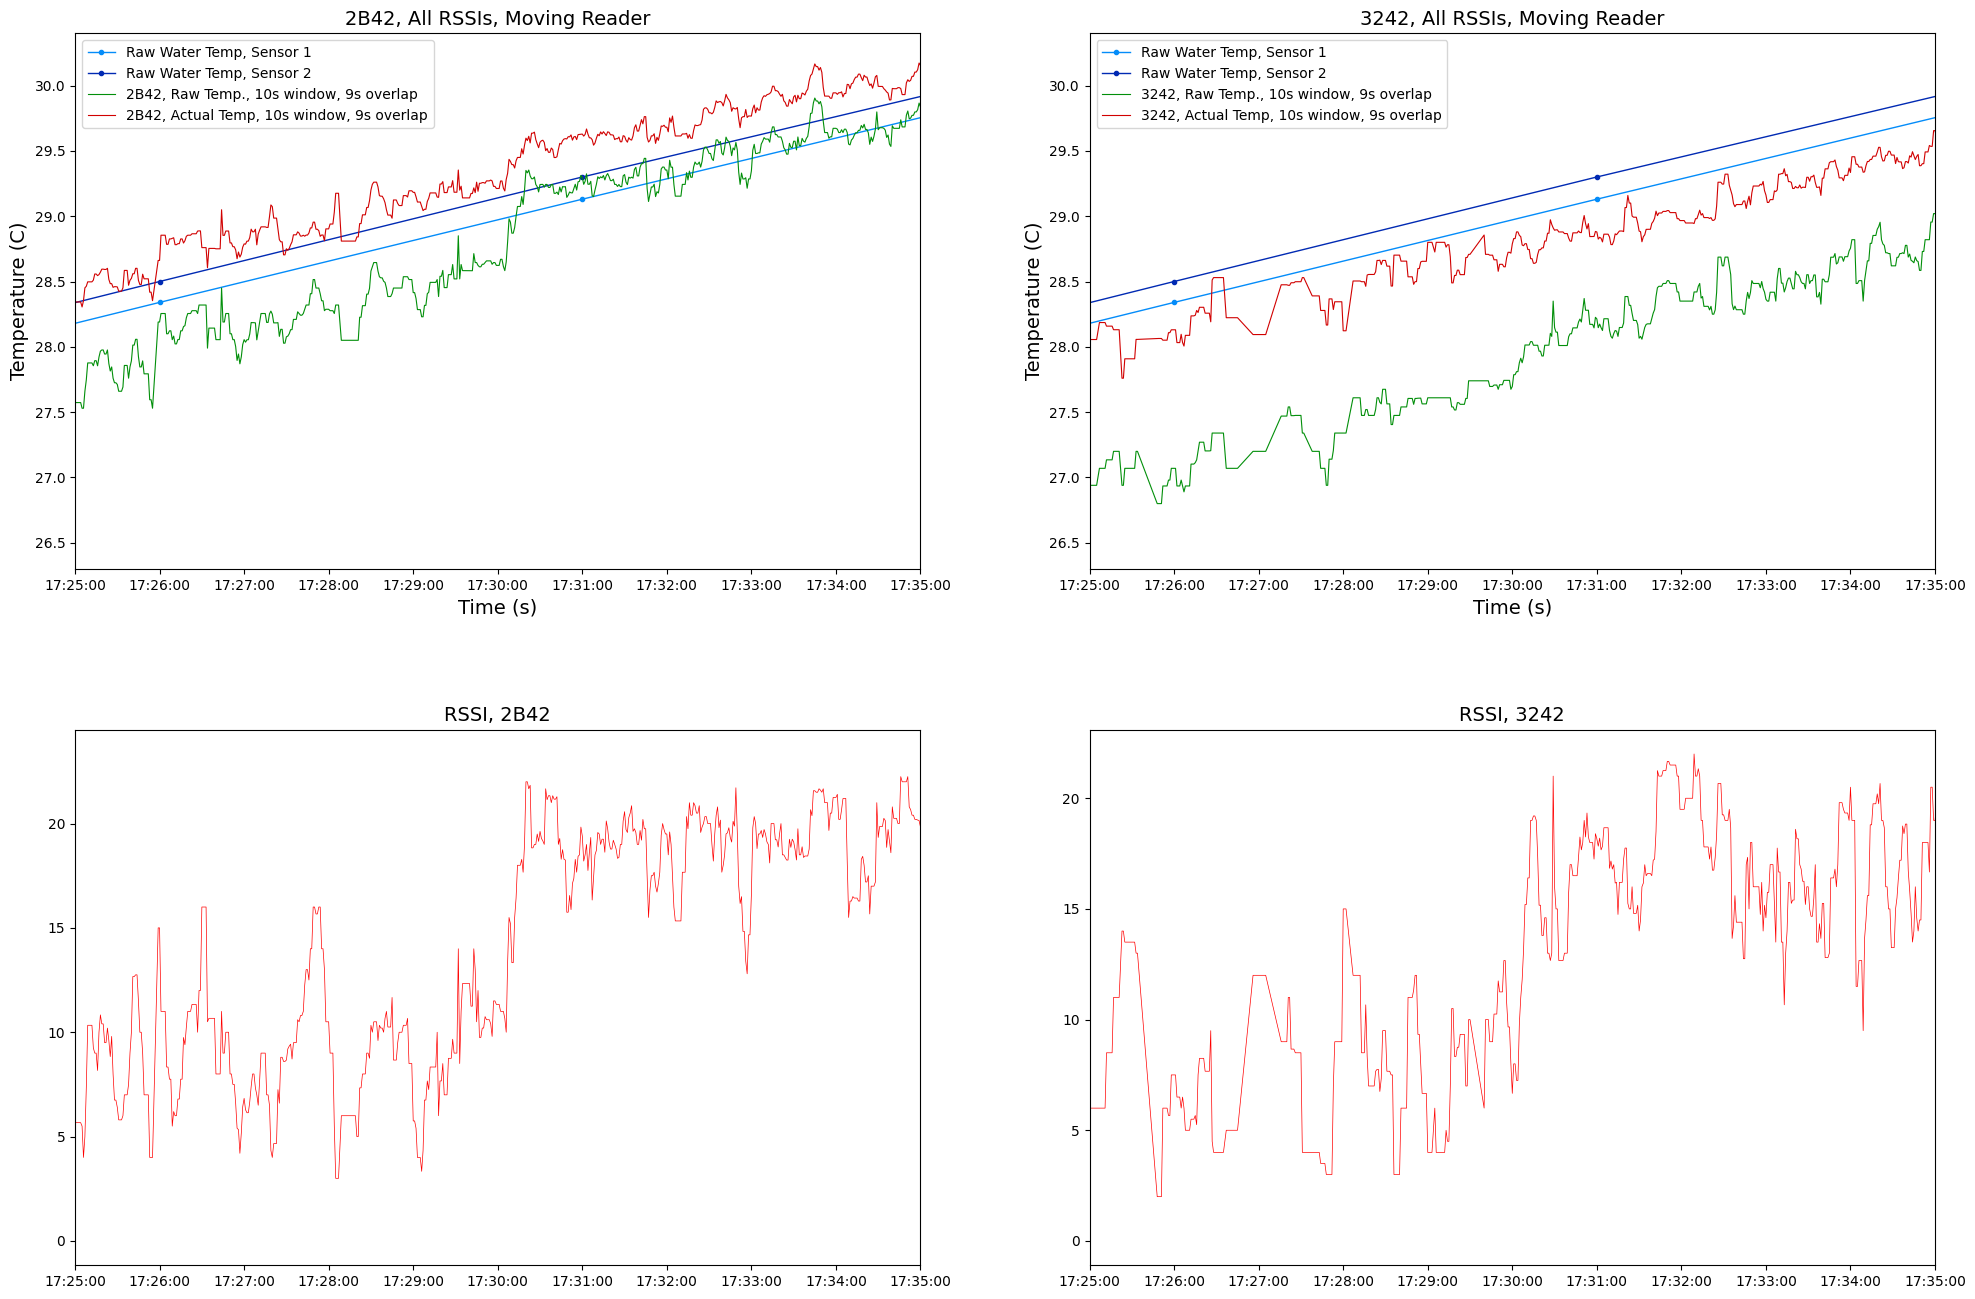

In [125]:
fig, ((ax1,ax2),(ax4,ax5)) = plt.subplots(2, 2, figsize=(24, 16), sharex=True)
fig.subplots_adjust(hspace=0.3)
axs = np.array([ [ax1, ax4], [ax2, ax5] ])

for a__ in axs.flatten():
    a__.xaxis.set_major_formatter( mdates.DateFormatter('%H:%M:%S') )
    a__.tick_params(labelbottom=True)
    a__.set_xlim( [datetime.datetime(1970, 2, 1, 17, 25, 0), datetime.datetime(1970, 2, 1, 17, 35, 0)] )

ax1.set_ylim(26.3, 30.4)
ax2.set_ylim(26.3, 30.4)

TAGS = [ '2B42', '3242', '3943' ]


def TimeMoveAvg(time, data, window):
    """
    """
    every, avgtime, avgdata = [], [], []
    t0 = time[0]
    while t0 < time[-1]:
        every.append([t0, t0 + datetime.timedelta(seconds=window)])
        t0 += datetime.timedelta(seconds=1)
    
    for j in range(len(every)): 
        d_ = []
        for ti,da in zip(time, data):
            if ti>=every[j][0] and ti<every[j][1]:
                d_.append(da)
        
        if len(d_)>0:
            avgdata.append(sum(d_)/len(d_))
            avgtime.append(every[j][0])
    
    return np.array(avgtime), np.array(avgdata)


for i in range(2):
    for k,v in temp.items():
        if k[-4:]==TAGS[i]:
            st, sr = sorted(temp[k].items()), sorted(rssi[k].items())
            dt = [ j[1] for j in st if j[0] > datetime.datetime(1970, 2, 1, 16, 23, 30) ]
            tt = [ j[0] for j in st if j[0] > datetime.datetime(1970, 2, 1, 16, 23, 30) ]
            dr = [ j[1] for j in sr if j[0] > datetime.datetime(1970, 2, 1, 16, 23, 30) ]

            RSSI_Time, TimeAverageRSSI = TimeMoveAvg(tt, dr, 10)
            axs[i][1].plot(RSSI_Time, TimeAverageRSSI, linewidth=0.5, color="r")
            axs[i][1].set_title("RSSI, " + TAGS[i], fontsize=14)
            
            new_dt, new_tt = [], []
            for p in range(len(dr)):
                if i==0:    actual = 0.032 * (9.83  - float(dr[p])) + float(dt[p]) + 0.6368
                elif i==1:  actual = 0.037 * (22.53 - float(dr[p])) + float(dt[p]) + 0.5043
                elif i==2:  actual = 0.048 * (2.84  - float(dr[p])) + float(dt[p]) + 1.0122
                new_dt.append(actual); new_tt.append(tt[p])

            axs[i][0].plot(s1_time, s1_data, label='Raw Water Temp, Sensor 1', linewidth=1.0, color="#048CF9", marker=".")
            axs[i][0].plot(s2_time, s2_data, label='Raw Water Temp, Sensor 2', linewidth=1.0, color="#012AB3", marker=".")

            RawAvgTime, TimeAvgRaw = TimeMoveAvg(tt, dt, 10)
            axs[i][0].plot(RawAvgTime, TimeAvgRaw, label=TAGS[i] + ", Raw Temp., 10s window, 9s overlap", linewidth=0.8, color="#028F0A")

            ActualAvgTime, TimeAvgActual = TimeMoveAvg(new_tt, new_dt, 10)
            axs[i][0].plot(ActualAvgTime, TimeAvgActual, label=TAGS[i] + ", Actual Temp, 10s window, 9s overlap", linewidth=0.8, color="#d10101")

            axs[i][0].set_ylabel('Temperature (C)', fontsize=14)
            axs[i][0].set_xlabel('Time (s)', fontsize=14)
            axs[i][0].set_title(TAGS[i] + ", All RSSIs, Moving Reader", fontsize=14)
            axs[i][0].legend()